Preparazione pacchetti

In [16]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import pyarrow.parquet as pq
from tqdm import tqdm


In [3]:
# === 1. Imposta la cartella dove hai scaricato i dati ===
DATASET_DIR = r"C:\Users\maria\Desktop\Zeek_ML\Final-Dataset"

# === 2. Carica tutti i file CSV e Parquet ===
all_dfs = []

for filename in os.listdir(DATASET_DIR):
    file_path = os.path.join(DATASET_DIR, filename)

    if filename.endswith(".csv"):
        print(f"[INFO] Caricamento CSV: {filename}")
        df = pd.read_csv(file_path)
        all_dfs.append(df)

    elif filename.endswith(".parquet"):
        print(f"[INFO] Caricamento PARQUET: {filename}")
        df = pd.read_parquet(file_path)
        all_dfs.append(df)

if not all_dfs:
    raise FileNotFoundError(f"Nessun file CSV o Parquet trovato in {DATASET_DIR}")

# === 3. Unisci tutto in un unico DataFrame ===
data = pd.concat(all_dfs, ignore_index=True)
print(f"[INFO] Dataset totale: {data.shape[0]} righe, {data.shape[1]} colonne")
print("[INFO] Colonne disponibili:", data.columns.tolist())


[INFO] Caricamento PARQUET: part-00000-1da06990-329c-4e38-913a-0f0aa39b388d-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-23fdcfa3-9dd3-4c72-886c-e945bfcf92e1-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-26e9208e-7819-451b-b23f-2e47f6d1e834-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-2b76f9cc-0710-45e4-9e33-98ad5808ee79-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-36240b61-b84f-4164-a873-d7973e652780-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-3f86626a-1225-47f9-a5a2-0170b737e404-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-745e350a-da9e-4619-bd52-8cc23bb41ad5-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-7c2e9adb-5430-4792-a42b-10ff5bbd46e8-c000.snappy.parquet
[INFO] Caricamento CSV: part-00000-8c53ceaf-1fd1-4711-aa7d-26d0c5323dab-c000.csv
[INFO] Caricamento PARQUET: part-00000-94d13437-ae00-4a8c-9f38-edd0196cfdee-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-9a46dd05-4b06-4a

In [4]:
# 🔹 Mostra tutte le colonne senza troncamenti
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

# === 🔹 Conteggio dei valori nulli per colonna + percentuale ===
null_counts = data.isna().sum()
null_percent = (null_counts / len(data)) * 100
null_table = pd.DataFrame({
    'null_count': null_counts,
    'null_percentage': null_percent
}).sort_values(by='null_count', ascending=False)

print("\n[INFO] Numero e percentuale di valori nulli per colonna:")
print(null_table)

# === 🔹 One-hot encoding di label_tactic e label_technique ===
tactic_dummies = pd.get_dummies(data['label_tactic'], prefix='tactic')
technique_dummies = pd.get_dummies(data['label_technique'], prefix='technique')

# 🔹 Unisci le nuove colonne al DataFrame originale
data_expanded = pd.concat([data, tactic_dummies, technique_dummies], axis=1)

# Mostra un esempio solo con le etichette espanse
expanded_cols = tactic_dummies.columns.tolist() + technique_dummies.columns.tolist()
print("\n[INFO] Prime righe con etichette espanse:")
print(data_expanded[expanded_cols].head(5))

# === 🔹 Salva i primi 30 elementi in un file Excel ===
data_expanded.head(30).to_excel("dataset_preview.xlsx", index=False)
print("\n[INFO] File Excel 'dataset_preview.xlsx' creato con i primi 30 elementi (etichette espanse incluse).")



[INFO] Numero e percentuale di valori nulli per colonna:
                         null_count  null_percentage
2022-01-16 - 2022-01-23    19262873        99.999969
2022-01-09 - 2022-01-16    19262873        99.999969
2022-02-06 - 2022-02-13    19262872        99.999964
2022-02-13 - 2022-02-20    19262865        99.999927
2022-10-09 - 2022-10-16    19262859        99.999896
2022-09-04 - 2022-09-11    19262859        99.999896
2022-09-11 - 2022-09-18    19262859        99.999896
2022-10-02 - 2022-10-09    19262856        99.999881
2022-09-18 - 2022-09-25    19262856        99.999881
2022-01-02 - 2022-01-09    19262855        99.999875
2021-12-12 - 2021-12-19    19262855        99.999875
2021-12-19 - 2021-12-26    19262855        99.999875
2021-12-26 - 2022-01-02    19262855        99.999875
2022-10-23 - 2022-10-30    19262855        99.999875
2022-08-28 - 2022-09-04    19262854        99.999870
2022-10-16 - 2022-10-23    19262848        99.999839
2022-09-25 - 2022-10-02    19262843      

Setup, colonne numeriche e ricerca colonne da rimuovere

In [6]:
import os
import pandas as pd

DATASET_DIR = r"C:\Users\maria\Desktop\Zeek_ML\Final-Dataset"

# 🔹 Colonne numeriche da trattare
numerical_cols = [
    'orig_bytes', 'resp_bytes', 'duration', 'orig_pkts', 
    'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes', 'missed_bytes'
]

# 🔹 Funzione per identificare colonne con >99% valori nulli
def get_high_null_columns(file_path, threshold=99.0, chunk_size=500_000):
    null_counts_total = None
    total_rows = 0
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        total_rows += len(chunk)
        if null_counts_total is None:
            null_counts_total = chunk.isna().sum()
        else:
            null_counts_total += chunk.isna().sum()
    null_percent = (null_counts_total / total_rows) * 100
    return null_percent[null_percent > threshold].index.tolist()

cols_to_drop = []
for filename in os.listdir(DATASET_DIR):
    file_path = os.path.join(DATASET_DIR, filename)
    if filename.endswith(".csv"):
        cols_to_drop.extend(get_high_null_columns(file_path))

cols_to_drop = list(set(cols_to_drop))
print(f"[INFO] Colonne da rimuovere (>99% null): {len(cols_to_drop)} -> {cols_to_drop}")


[INFO] Colonne da rimuovere (>99% null): 0 -> []


Riempimento NaN e codifica etichette

In [10]:
from sklearn.preprocessing import LabelEncoder

# 🔹 Calcolo media globale per colonne numeriche
global_means = data_clean[numerical_cols].mean()
data_clean[numerical_cols] = data_clean[numerical_cols].fillna(global_means)
# Se colonna era completamente NaN -> riempi con 0
data_clean[numerical_cols] = data_clean[numerical_cols].fillna(0)

# 🔹 Riempimento NaN in colonne categoriche
for col in data_clean.select_dtypes(include='category').columns:
    data_clean[col] = data_clean[col].cat.add_categories(["unknown"]).fillna("unknown")

# 🔹 Codifica etichette
label_encoder_tactic = LabelEncoder()
data_clean['label_tactic_encoded'] = label_encoder_tactic.fit_transform(data_clean['label_tactic'])

label_encoder_technique = LabelEncoder()
data_clean['label_technique_encoded'] = label_encoder_technique.fit_transform(data_clean['label_technique'])

print("[INFO] Pulizia valori nulli completata")


[INFO] Pulizia valori nulli completata


Filtraggio tattiche valide

In [13]:
valid_tactics = [
    "Reconnaissance", "Discovery", "Credential Access", "Privilege Escalation",
    "Exfiltration", "Lateral Movement", "Resource Development", "Initial Access",
    "Persistence", "Defense Evasion"
]

# 🔹 Filtra solo tattiche valide + none
data_clean = data_clean[data_clean['label_tactic'].isin(valid_tactics + ["none"])]

# 🔹 Rimuovi eventuali etichette spurie
data_clean = data_clean[~data_clean['label_tactic'].isin([
    "unknown", "dt_first_record", "dt_last_record", 
    "dt_week_end", "dt_week_start", "total_record_count"
])]

# 🔹 Ricodifica le etichette dopo il filtraggio
data_clean['label_tactic_encoded'] = LabelEncoder().fit_transform(data_clean['label_tactic'])

print(f"[INFO] Dataset dopo filtraggio: {data_clean.shape[0]} righe")
print("[INFO] Distribuzione classi label_tactic:")
print(data_clean['label_tactic'].value_counts())

print(data_clean['label_tactic'].unique())
print(data_clean['label_tactic'].isna().sum())


[INFO] Dataset dopo filtraggio: 19262781 righe
[INFO] Distribuzione classi label_tactic:
label_tactic
none                    9631940
Reconnaissance          9330216
Resource Development     275476
Discovery                 18907
Privilege Escalation       3081
Defense Evasion            3067
Credential Access            34
Initial Access               22
Lateral Movement             17
Persistence                  13
Exfiltration                  8
Name: count, dtype: int64
['Defense Evasion' 'Initial Access' 'Persistence' 'Privilege Escalation'
 'Exfiltration' 'Lateral Movement' 'Reconnaissance' 'Credential Access'
 'Resource Development' 'none' 'Discovery']
0


Standardizzazione + PCA incrementale (2 passate)

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
import numpy as np

chunksize = 100_000

# 🔹 Prima passata: calcola media e std globali con StandardScaler
scaler = StandardScaler()
for start in range(0, len(data_clean), chunksize):
    batch = data_clean[numerical_cols].iloc[start:start+chunksize].values.astype(np.float32)
    scaler.partial_fit(batch)
print("[INFO] StandardScaler fitted su tutto il dataset")

# 🔹 Seconda passata: PCA incrementale sui dati normalizzati
pca = IncrementalPCA(n_components=2)
for start in range(0, len(data_clean), chunksize):
    batch = data_clean[numerical_cols].iloc[start:start+chunksize].values.astype(np.float32)
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)
print("[INFO] PCA incrementale fitted su tutto il dataset")


[INFO] StandardScaler fitted su tutto il dataset
[INFO] PCA incrementale fitted su tutto il dataset


Trasformazione finale + salvataggio su Parquet

In [15]:
import pyarrow as pa
import pyarrow.parquet as pq

output_dir = "dataset_pca_incremental"
os.makedirs(output_dir, exist_ok=True)

for start in range(0, len(data_clean), chunksize):
    batch = data_clean[numerical_cols].iloc[start:start+chunksize].values.astype(np.float32)
    batch_scaled = scaler.transform(batch)
    batch_pca = pca.transform(batch_scaled)
    
    batch_labels = data_clean['label_tactic'].iloc[start:start+chunksize].values
    table = pa.Table.from_arrays(
        [pa.array(batch_pca[:,0], type=pa.float32()),
         pa.array(batch_pca[:,1], type=pa.float32()),
         pa.array(batch_labels.astype(str))],
        names=['PC1','PC2','label_tactic']
    )
    pq.write_to_dataset(table, root_path=output_dir)

print(f"[INFO] PCA batch salvata in cartella: {output_dir}")


[INFO] PCA batch salvata in cartella: dataset_pca_incremental


Grafico PCA

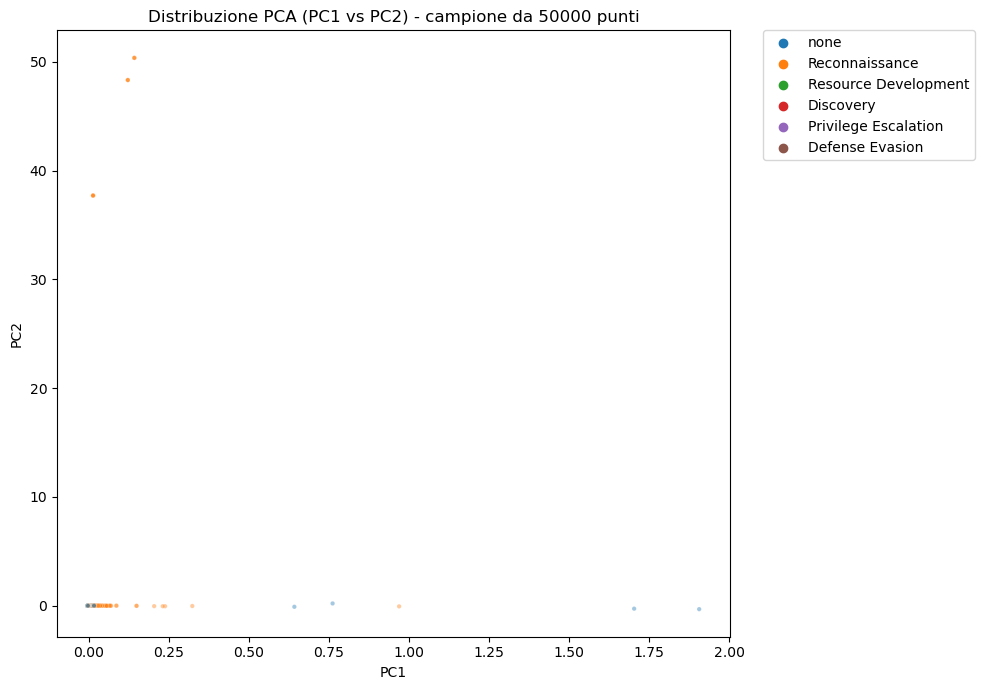


📊 INTERPRETAZIONE DEL GRAFICO:
- Ogni punto rappresenta un record del dataset, proiettato nello spazio bidimensionale usando le prime due Componenti Principali (PC1, PC2).
- I colori indicano la tattica associata (MITRE ATT&CK).
- Le aree più dense indicano gruppi di eventi con caratteristiche simili.
- Puoi confrontare la distribuzione di 'none' (normale) con le tattiche reali: cluster ben separati possono indicare pattern utili per classificatori.


In [3]:
import seaborn as sns

# === 3️⃣ Scatter plot (migliorato per leggibilità) ===
max_points = 50_000  # campione più piccolo per leggibilità
sample_df = pca_df.sample(min(max_points, len(pca_df)))

plt.figure(figsize=(10, 7))

palette = sns.color_palette("tab10", n_colors=sample_df['label_tactic'].nunique())
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="label_tactic",
    data=sample_df,
    palette=palette,
    s=10,
    alpha=0.4,
    legend="full"
)

plt.title(f"Distribuzione PCA (PC1 vs PC2) - campione da {len(sample_df)} punti")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

# === 3️⃣ BIS: Spiegazione testuale ===
print("\n📊 INTERPRETAZIONE DEL GRAFICO:")
print(
    f"- Ogni punto rappresenta un record del dataset, proiettato nello spazio bidimensionale "
    f"usando le prime due Componenti Principali (PC1, PC2).\n"
    f"- I colori indicano la tattica associata (MITRE ATT&CK).\n"
    f"- Le aree più dense indicano gruppi di eventi con caratteristiche simili.\n"
    f"- Puoi confrontare la distribuzione di 'none' (normale) con le tattiche reali: "
    f"cluster ben separati possono indicare pattern utili per classificatori."
)


Splitting di dataset

In [ ]:
# === 7. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"[INFO] Train set: {X_train.shape}, Test set: {X_test.shape}")

# (Opzionale: salva i dati pre-processati per usarli in un altro script)
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("[INFO] Preprocessing completato ✅")